In [109]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import re
nt_list = ["A", "T", "C", "G"]

"""
FACTOR="SP1"; KMERLIST = ['ATTGG',
 'CCAAT',
 'GATTG',
 'CAATC',
 'TTCCG',
 'CATTG',
 'CGATT',
 'CGTCA',
 'CGGAA',
 'AATCG']
 """
"""
FACTOR="USF1"; KMERLIST = ['CCAAT',
 'CACGT',
 'ACGTG',
 'ATTGG',
 'TTCCG',
 'CGGAA',
 'CAATC',
 'TCACG',
 'GCCAA',
 'GATTG'] # NFY and USF spatial https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5219757/
"""
"""
FACTOR="ZBTB33"; KMERLIST=['TTCCG',
 'TATCG',
 'TCACG',
 'CGGAA',
 'CGTCA',
 'CACGA',
 'ATTGG',
 'CGTGA',
 'ACGAG',
 'TCGCG']
 """
"""
FACTOR ="RUNX3"; KMERLIST=['ACCAC',
 'GTGGT',
 'AACCA',
 'TTCCG',
 'AAACC',
 'CCACA',
 'TGGTT',
 'TGTGG',
 'AGTCA',
 'CGAAA']
 """
FACTOR = "RUNX3"; KMERLIST = ["AAAAA","TTTTT","ACACA","TGTGT"]

Populating the interactive namespace from numpy and matplotlib


In [110]:
# convert one-hot arrays to sequences
def convert_to_seq(seq_raw):
    seq_vec = np.array(seq_raw.split(","), dtype=int).reshape([1000,4])
    seq = ""
    for nt_arr in seq_vec:
        pos = np.where(nt_arr == 1)[0]
        if pos.shape[0] != 1:
            raise ValueError
        else:
            seq += nt_list[pos[0]]
    return seq

In [111]:
def find_kmer(TF_name, kmer):
    # returns dict of pos->matches
    MAXCOUNT = 1000000
    f_samples = "/storage/pandaman/project/AgentBind-GM12878-analysis/tmp/"\
                    + "%s+GM12878/seqs_one_hot_c/vis-samples/data.txt" %(TF_name)
    pos_stat = {}
    linecount = 0
    for line in open(f_samples):
        linecount += 1
        if linecount > MAXCOUNT:
            break
        seq_raw, label, info = line.split(";")
        try:
            seq = convert_to_seq(seq_raw)
        except: continue

        elems = info.strip().split(",")
        chromID, seq_start, seq_end, strand = elems[3], int(elems[6]), int(elems[7]) , elems[8]
        seq_start, seq_end = seq_start+1, seq_end+1 #0-based to 1-based
        
        # identify matched kmers
        matches = [m.start() for m in re.finditer('(?=%s)' %(kmer), seq)]
        
        # record the relative positions
        for m in matches:
            if m not in pos_stat:
                pos_stat[m] = 0
            pos_stat[m] += 1

        if strand == "-":
            matches = [1000-m-len(kmer) for m in matches]
            matches = matches[::-1]
        
        if len(matches) != 0:
            print_msg = "Sequence: %s:%d-%d %s\t" %(chromID, seq_start, seq_end, strand) +\
                  "Matched kmers start at: %s: " %(chromID) +\
                  (", ".join(["%d(%d)" %(m+seq_start, m) for m in matches]))
            
            # uncomment the following line to see all the positions of matches
            # print (print_msg)
        
    return pos_stat

In [112]:
# Get for each kmer
all_pos_stat = {} # motif -> pos_stat
for KMER in KMERLIST:
    all_pos_stat[KMER] = find_kmer(FACTOR, KMER)
    print("%s: %s"%(KMER, sum([v for v in all_pos_stat[KMER].values()])))

AAAAA: 124431
TTTTT: 91826
ACACA: 65924
TGTGT: 30287


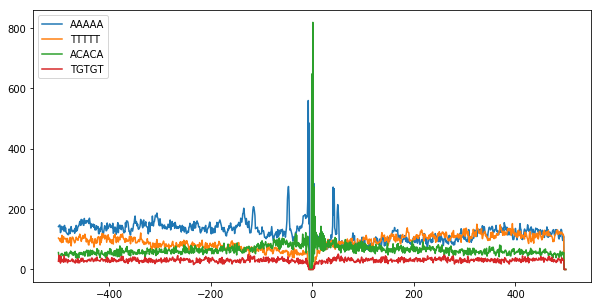

In [113]:
# Plot for multiple kmers - heatmap or smoothed line plot

def Smooth(vals, m=0):
    if m == 0: return vals
    newvals = []
    for i in range(len(vals)):
        leftind = max([0, i-m])
        rightind = min([len(vals), i+m])
        newvals.append(np.mean(vals[leftind:rightind]))
    return newvals

xvals = [pos-500 for pos in range(1000)] 
fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
klist = KMERLIST #KMERLIST
for kmer in klist:
    pos_stat = all_pos_stat[kmer]
    yvals = Smooth([pos_stat.get(pos, 0) for pos in range(1000)])
    #for i in range(490, 510): yvals[i] = 0 # core
    ax.plot(xvals, yvals, label=kmer)
#ax.set_xlim(left=-100, right=100)
ax.legend(loc="upper left")
#ax.set_ylim(bottom=0, top=50)
fig.savefig("MultiKmer-%s-%s.pdf"%(FACTOR, "-".join(klist)))


In [114]:
# For SP1, spike in polyT (but not polyA) at +/- 75bp. sign of nucleosome positioning?